# Clustering Analysis - Student Alcohol Consumption Dataset

Questo notebook implementa:
- K-Means Clustering
- Hierarchical Clustering
- Valutazione dei cluster (Silhouette Coefficient, Elbow Method)
- Assegnazione di nomi ai cluster
- Confronto dei cluster con Radar Plot


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


In [52]:
# Carica il dataset
df = pd.read_excel("df_merge.xlsx")
print(f"Dataset shape: {df.shape}")
print(f"\nPrime righe:")
df.head()


Dataset shape: (1044, 34)

Prime righe:


,Dalc,Fedu,Fjob,G1,G2,G3,Medu,Mjob,Pstatus,Walc,...,nursery,paid,reason,romantic,school,schoolsup,sex,studytime,subject,traveltime
0,1,4,teacher,5,6,6,4,at_home,A,1,...,yes,no,course,no,GP,yes,F,2,math,2
1,1,1,other,5,5,6,1,at_home,T,1,...,no,no,course,no,GP,no,F,2,math,1
2,2,1,other,7,8,10,1,at_home,T,3,...,yes,yes,other,no,GP,yes,F,2,math,1
3,1,2,services,15,14,15,4,health,T,1,...,yes,yes,home,yes,GP,no,F,3,math,1
4,1,3,other,6,10,10,3,other,T,2,...,yes,yes,home,no,GP,no,F,2,math,1


## 1. Preprocessing dei Dati


In [53]:
# Seleziona le variabili numeriche rilevanti per il clustering
# Escludiamo i voti (G1, G2, G3) per creare cluster basati su caratteristiche comportamentali
features_for_clustering = [
    'age', 'Medu', 'Fedu',  # Caratteristiche demografiche
    'studytime', 'failures', 'absences',  # Performance scolastica
    'famrel', 'freetime', 'goout',  # Vita sociale e familiare
    'Dalc', 'Walc',  # Consumo di alcol
    'health', 'traveltime'  # Salute e mobilità
]

# Verifica che tutte le colonne esistano
available_features = [col for col in features_for_clustering if col in df.columns]
print(f"Features selezionate: {len(available_features)}")
print(f"Features: {available_features}")

# Crea dataset per clustering
X = df[available_features].copy()

# Gestisci valori mancanti
print(f"\nValori mancanti per colonna:")
print(X.isnull().sum())
X = X.fillna(X.median())

print(f"\nDataset per clustering: {X.shape}")
X.head()


Features selezionate: 13
Features: ['age', 'Medu', 'Fedu', 'studytime', 'failures', 'absences', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'traveltime']

Valori mancanti per colonna:
age           0
Medu          0
Fedu          0
studytime     0
failures      0
absences      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
traveltime    0
dtype: int64

Dataset per clustering: (1044, 13)


,age,Medu,Fedu,studytime,failures,absences,famrel,freetime,goout,Dalc,Walc,health,traveltime
0,18,4,4,2,0,6,4,3,4,1,1,3,2
1,17,1,1,2,0,4,5,3,3,1,1,3,1
2,15,1,1,2,3,10,4,3,2,2,3,3,1
3,15,4,2,3,0,2,3,2,2,1,1,5,1
4,16,3,3,2,0,4,4,3,2,1,2,5,1


In [54]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# Normalizzazione dei dati (importante per clustering)
# scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features, index=X.index)

print("Dati normalizzati:")
print(X_scaled_df.describe())
print(f"\nShape: {X_scaled_df.shape}")


Dati normalizzati:
               age         Medu         Fedu    studytime     failures  \
count  1044.000000  1044.000000  1044.000000  1044.000000  1044.000000   
mean     -0.136973    -0.198276     0.193966    -0.029693     0.264368   
std       0.619987     0.562453     0.549969     0.834353     0.656142   
min      -1.000000    -1.500000    -1.000000    -1.000000     0.000000   
25%      -0.500000    -0.500000    -0.500000    -1.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.500000     0.500000     0.500000     0.000000     0.000000   
max       2.500000     0.500000     1.000000     2.000000     3.000000   

          absences       famrel     freetime        goout         Dalc  \
count  1044.000000  1044.000000  1044.000000  1044.000000  1044.000000   
mean      0.405811    -0.064176     0.201149     0.078065     0.494253   
std       1.035003     0.933401     1.031507     0.576287     0.911714   
min      -0.333333

## 2. Elbow Method per Determinare il Numero Ottimale di Cluster


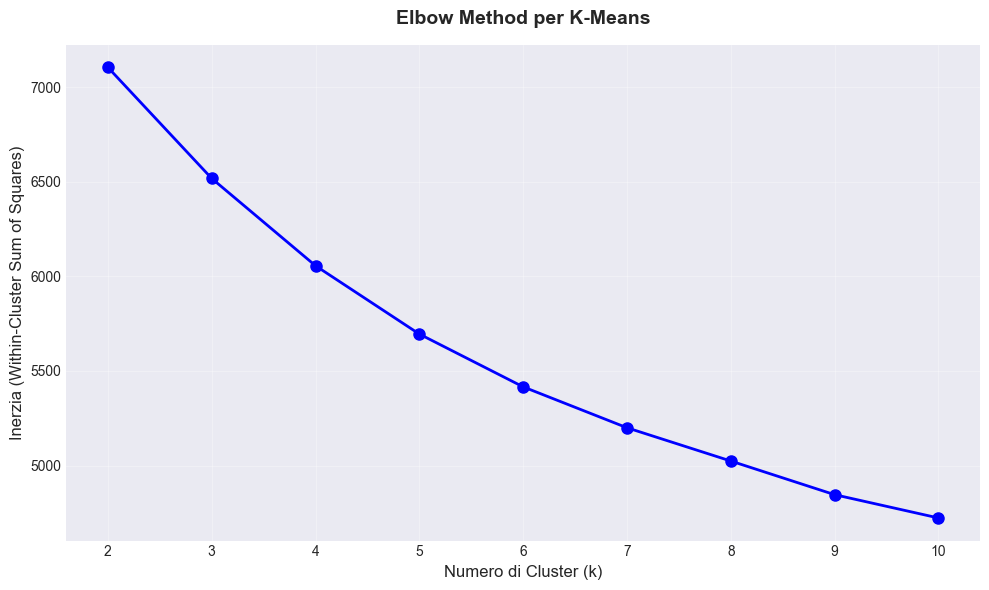

Inerzie per ogni k:
k=2: 7105.53
k=3: 6518.25
k=4: 6056.48
k=5: 5695.28
k=6: 5416.17
k=7: 5199.85
k=8: 5023.95
k=9: 4846.01
k=10: 4722.84


In [55]:
# Elbow Method per K-Means
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualizza Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Numero di Cluster (k)', fontsize=12)
plt.ylabel('Inerzia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method per K-Means', fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

print("Inerzie per ogni k:")
for k, inertia in zip(K_range, inertias):
    print(f"k={k}: {inertia:.2f}")


## 3. Silhouette Coefficient per Valutare i Cluster


k=2: Silhouette Score = 0.1949
k=3: Silhouette Score = 0.1111
k=4: Silhouette Score = 0.1134
k=5: Silhouette Score = 0.1010
k=6: Silhouette Score = 0.0958
k=7: Silhouette Score = 0.0959
k=8: Silhouette Score = 0.0957
k=9: Silhouette Score = 0.1038
k=10: Silhouette Score = 0.0900


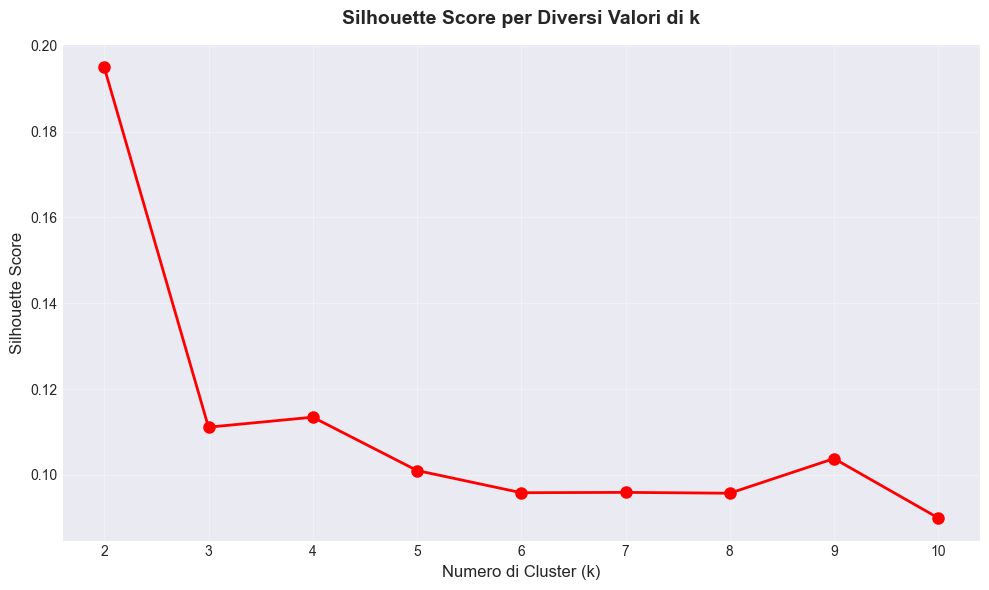


Numero ottimale di cluster (basato su Silhouette): k=2
Silhouette Score massimo: 0.1949


In [56]:
# Calcola Silhouette Score per diversi valori di k
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

# Visualizza Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Numero di Cluster (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score per Diversi Valori di k', fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

# Trova il k ottimale
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nNumero ottimale di cluster (basato su Silhouette): k={optimal_k}")
print(f"Silhouette Score massimo: {max(silhouette_scores):.4f}")


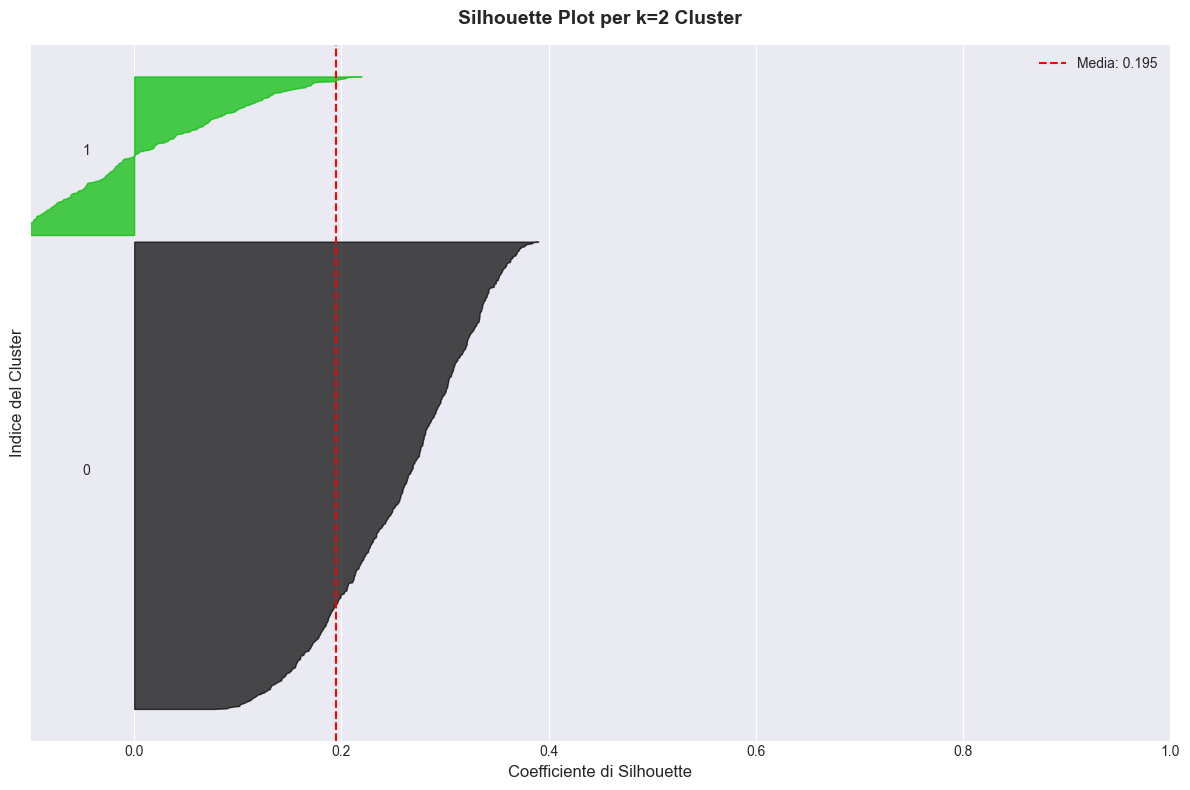

In [57]:
# Silhouette Plot dettagliato per k ottimale
k_optimal = optimal_k
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_scaled)

# Calcola silhouette samples
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels_optimal)
silhouette_avg = silhouette_score(X_scaled, cluster_labels_optimal)

# Crea silhouette plot
fig, ax = plt.subplots(figsize=(12, 8))
y_lower = 10

for i in range(k_optimal):
    # Raggruppa i valori di silhouette per cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_optimal == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / k_optimal)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etichetta il cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax.set_title(f'Silhouette Plot per k={k_optimal} Cluster', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Coefficiente di Silhouette', fontsize=12)
ax.set_ylabel('Indice del Cluster', fontsize=12)
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Media: {silhouette_avg:.3f}')
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.legend()
plt.tight_layout()
plt.show()


## 4. K-Means Clustering


In [ ]:
# Applica K-Means con k ottimale
# Invece di usare k_optimal calcolato automaticamente
# n_clusters = k_optimal 

# Forziamo a 3 o 4 per vedere sfumature comportamentali
n_clusters = 4 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Aggiungi le etichette al dataset originale
df['cluster_kmeans'] = kmeans_labels

print(f"K-Means applicato con {n_clusters} cluster")
print(f"\nDistribuzione dei cluster:")
print(df['cluster_kmeans'].value_counts().sort_index())
print(f"\nSilhouette Score: {silhouette_score(X_scaled, kmeans_labels):.4f}")


K-Means applicato con 4 cluster

Distribuzione dei cluster:
cluster_kmeans
0    296
1    178
2     77
3    493
Name: count, dtype: int64

Silhouette Score: 0.1134


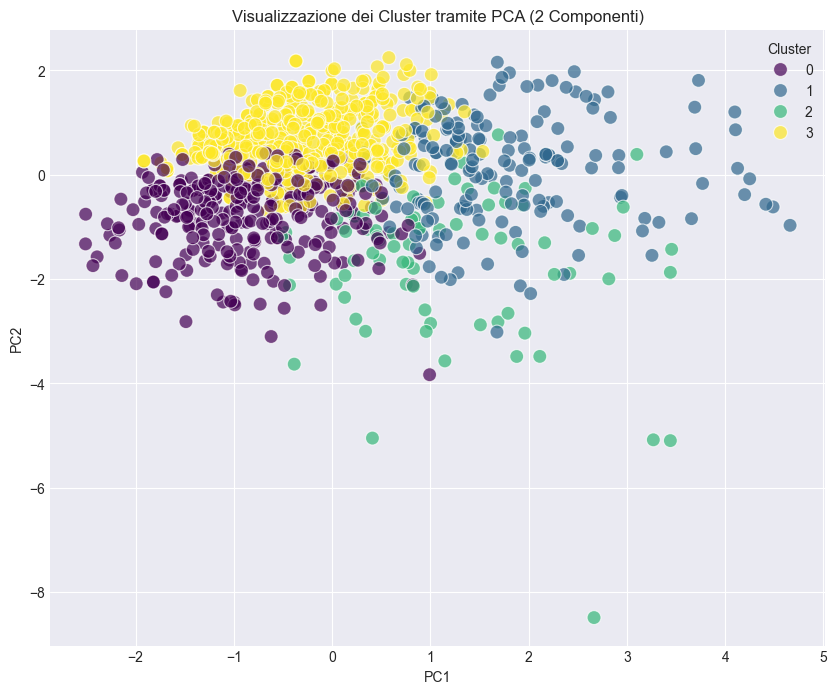

In [59]:
from sklearn.decomposition import PCA

# Riduci a 2 dimensioni per visualizzare
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crea un DataFrame per il plot
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Visualizzazione dei Cluster tramite PCA (2 Componenti)')
plt.show()

In [60]:
# Analizza i centroidi dei cluster (in scala originale)
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=available_features)
centroids_df.index = [f'Cluster {i}' for i in range(n_clusters)]

print("Centroidi dei cluster (valori originali):")
centroids_df


Centroidi dei cluster (valori originali):


,age,Medu,Fedu,studytime,failures,absences,famrel,freetime,goout,Dalc,Walc,health,traveltime
Cluster 0,16.618243,2.516892,2.229730,1.918919,0.202703,3.141892,3.445946,2.165541,2.527027,1.239865,1.932432,3.219595,1.611486
Cluster 1,17.033708,2.370787,2.264045,1.528090,0.511236,4.724719,3.887640,3.719101,3.977528,2.977528,4.056180,3.971910,1.842697
Cluster 2,17.155844,2.753247,2.610390,1.701299,0.545455,19.779221,3.727273,3.194805,3.272727,1.519481,2.571429,3.623377,1.402597
Cluster 3,16.612576,2.716024,2.492901,2.202840,0.168357,2.709939,4.279919,3.636917,3.219067,1.107505,1.811359,3.569980,1.373225


## 5. Hierarchical Clustering


Usando un campione di 200 osservazioni per il dendrogramma


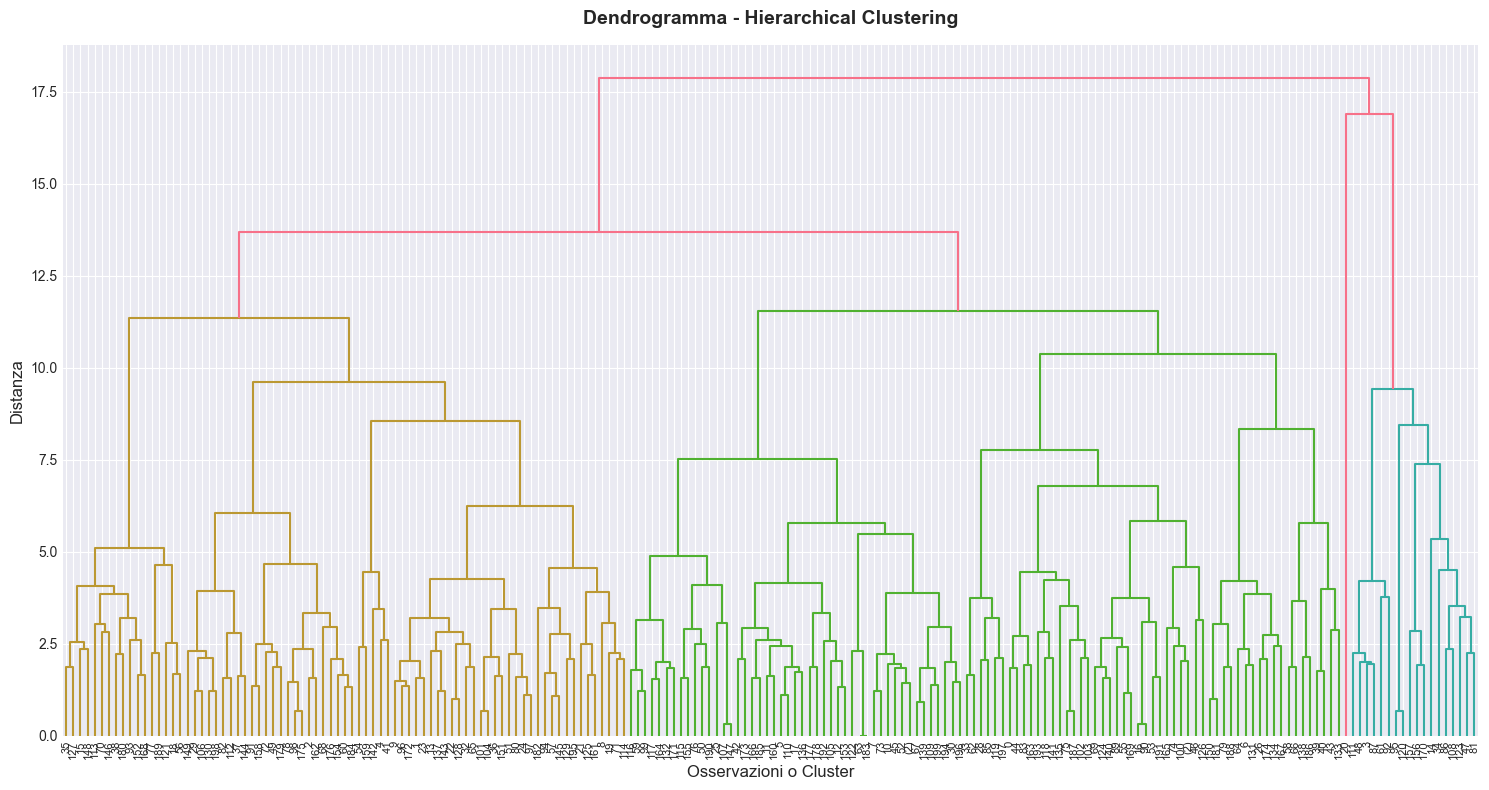

In [ ]:
# Crea dendrogramma per Hierarchical Clustering
# Usa un campione per velocità (opzionale, rimuovi se vuoi tutti i dati)
sample_size = min(200, len(X_scaled))
if sample_size < len(X_scaled):
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    print(f"Usando un campione di {sample_size} osservazioni per il dendrogramma")
else:
    X_sample = X_scaled
    sample_indices = np.arange(len(X_scaled))

# Calcola linkage matrix
linkage_matrix = linkage(X_sample, method='ward')

# Crea dendrogramma
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogramma - Hierarchical Clustering', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Osservazioni o Cluster', fontsize=12)
plt.ylabel('Distanza', fontsize=12)
plt.tight_layout()
plt.show()


In [62]:
# Applica Hierarchical Clustering con lo stesso numero di cluster
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Aggiungi le etichette al dataset
df['cluster_hierarchical'] = hierarchical_labels

print(f"Hierarchical Clustering applicato con {n_clusters} cluster")
print(f"\nDistribuzione dei cluster:")
print(df['cluster_hierarchical'].value_counts().sort_index())
print(f"\nSilhouette Score: {silhouette_score(X_scaled, hierarchical_labels):.4f}")


Hierarchical Clustering applicato con 4 cluster

Distribuzione dei cluster:
cluster_hierarchical
0    181
1    505
2    269
3     89
Name: count, dtype: int64

Silhouette Score: 0.0838


Confronto tra K-Means e Hierarchical Clustering:
cluster_hierarchical    0    1    2   3  Total
cluster_kmeans                                
0                       7   81  205   3    296
1                      50   36   11  81    178
2                      57    1   15   4     77
3                      67  387   38   1    493
Total                 181  505  269  89   1044


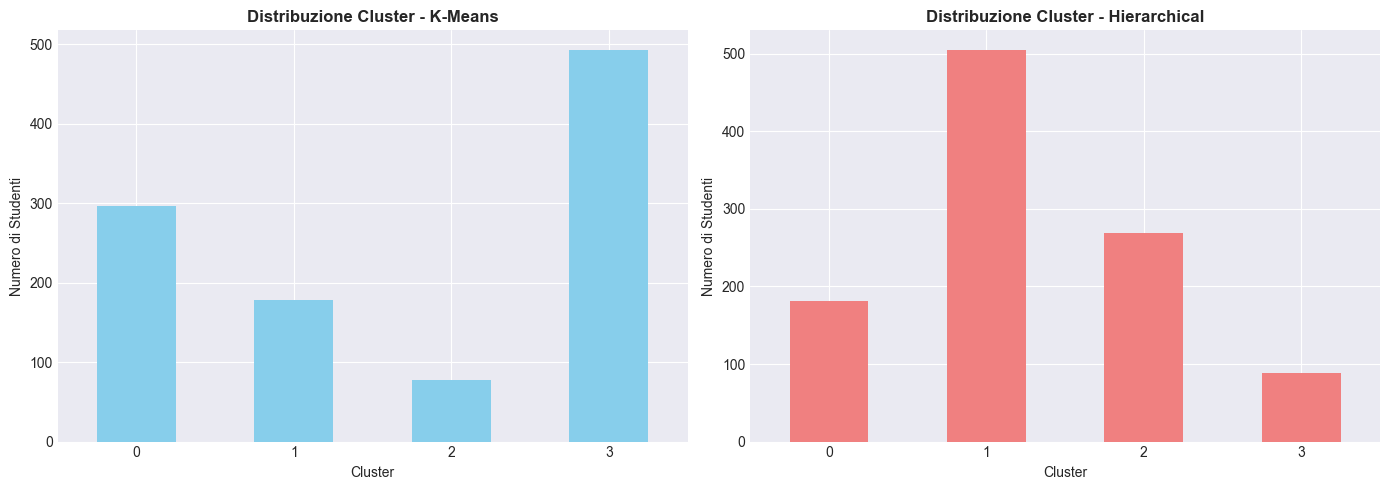

In [63]:
# Confronta i due metodi
comparison = pd.crosstab(df['cluster_kmeans'], df['cluster_hierarchical'], 
                        margins=True, margins_name='Total')
print("Confronto tra K-Means e Hierarchical Clustering:")
print(comparison)

# Visualizza distribuzione cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['cluster_kmeans'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribuzione Cluster - K-Means', fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Numero di Studenti')
axes[0].tick_params(axis='x', rotation=0)

df['cluster_hierarchical'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Distribuzione Cluster - Hierarchical', fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Numero di Studenti')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


## 6. Assegnazione Nomi ai Cluster


In [64]:
# Analizza le caratteristiche medie di ogni cluster (K-Means)
cluster_profiles = df.groupby('cluster_kmeans')[available_features + ['G1', 'G2', 'G3']].mean()

print("Profilo medio dei cluster (K-Means):")
cluster_profiles


Profilo medio dei cluster (K-Means):


,age,Medu,Fedu,studytime,failures,absences,famrel,freetime,goout,Dalc,Walc,health,traveltime,G1,G2,G3
cluster_kmeans,,,,,,,,,,,,,,,,
0,16.618243,2.516892,2.229730,1.918919,0.202703,3.141892,3.445946,2.165541,2.527027,1.239865,1.932432,3.219595,1.611486,11.347973,11.395270,11.439189
1,17.033708,2.370787,2.264045,1.528090,0.511236,4.724719,3.887640,3.719101,3.977528,2.977528,4.056180,3.971910,1.842697,9.904494,9.955056,9.915730
2,17.155844,2.753247,2.610390,1.701299,0.545455,19.779221,3.727273,3.194805,3.272727,1.519481,2.571429,3.623377,1.402597,10.506494,10.142857,10.298701
3,16.612576,2.716024,2.492901,2.202840,0.168357,2.709939,4.279919,3.636917,3.219067,1.107505,1.811359,3.569980,1.373225,11.716024,11.795132,11.961460


In [65]:
# Funzione per assegnare nomi ai cluster basandosi sulle loro caratteristiche
def assign_cluster_names(cluster_profiles):
    """
    Assegna nomi descrittivi ai cluster basandosi sulle loro caratteristiche medie
    """
    cluster_names = {}
    
    for cluster_id in cluster_profiles.index:
        profile = cluster_profiles.loc[cluster_id]
        
        # Analizza caratteristiche chiave
        avg_grade = profile[['G1', 'G2', 'G3']].mean()
        avg_alcohol = (profile['Dalc'] + profile['Walc']) / 2
        study_time = profile['studytime']
        absences = profile['absences']
        failures = profile['failures']
        social_life = (profile['goout'] + profile['freetime']) / 2
        
        # Determina nome del cluster
        name_parts = []
        
        # Performance scolastica
        if avg_grade >= 12:
            name_parts.append("Eccellenti")
        elif avg_grade >= 10:
            name_parts.append("Buoni")
        elif avg_grade >= 7:
            name_parts.append("Medi")
        else:
            name_parts.append("Scarsi")
        
        # Consumo alcol
        if avg_alcohol >= 3:
            name_parts.append("Alto Alcol")
        elif avg_alcohol >= 2:
            name_parts.append("Moderato Alcol")
        else:
            name_parts.append("Basso Alcol")
        
        # Impegno nello studio
        if study_time >= 3 and absences < 5:
            name_parts.append("Studiosi")
        elif study_time < 2 or absences > 10:
            name_parts.append("Poco Impegnati")
        
        # Vita sociale
        if social_life >= 3.5:
            name_parts.append("Sociali")
        elif social_life <= 2:
            name_parts.append("Riservati")
        
        # Crea nome finale (prendi i primi 2-3 elementi più rilevanti)
        if len(name_parts) > 2:
            cluster_name = f"{name_parts[0]} - {name_parts[1]}"
        else:
            cluster_name = " - ".join(name_parts)
        
        cluster_names[cluster_id] = cluster_name
    
    return cluster_names

# Assegna nomi ai cluster
cluster_names_dict = assign_cluster_names(cluster_profiles)

print("Nomi assegnati ai cluster:")
for cluster_id, name in cluster_names_dict.items():
    print(f"Cluster {cluster_id}: {name}")

# Crea mappatura
df['cluster_name'] = df['cluster_kmeans'].map(cluster_names_dict)

# Mostra distribuzione
print("\nDistribuzione dei cluster nominati:")
print(df['cluster_name'].value_counts())


Nomi assegnati ai cluster:
Cluster 0: Buoni - Basso Alcol
Cluster 1: Medi - Alto Alcol
Cluster 2: Buoni - Moderato Alcol
Cluster 3: Buoni - Basso Alcol

Distribuzione dei cluster nominati:
cluster_name
Buoni - Basso Alcol       789
Medi - Alto Alcol         178
Buoni - Moderato Alcol     77
Name: count, dtype: int64


In [66]:
def create_radar_plot(cluster_profiles, features_to_plot, cluster_names_dict, title="Radar Plot Cluster"):
    """
    Crea un radar plot per confrontare i cluster
    """
    # Normalizza le features per il radar plot (0-1 scale)
    normalized_profiles = cluster_profiles[features_to_plot].copy()
    
    # Normalizza ogni feature tra 0 e 1
    for feature in features_to_plot:
        min_val = normalized_profiles[feature].min()
        max_val = normalized_profiles[feature].max()
        if max_val - min_val > 0:
            normalized_profiles[feature] = (normalized_profiles[feature] - min_val) / (max_val - min_val)
    
    # Numero di variabili
    N = len(features_to_plot)
    
    # Angoli per ogni asse
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Chiudi il cerchio
    
    # Crea figura
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    # Colori per ogni cluster
    colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_profiles)))
    
    # Plot per ogni cluster
    for idx, cluster_id in enumerate(cluster_profiles.index):
        values = normalized_profiles.loc[cluster_id].values.tolist()
        values += values[:1]  # Chiudi il cerchio
        
        cluster_name = cluster_names_dict.get(cluster_id, f'Cluster {cluster_id}')
        ax.plot(angles, values, 'o-', linewidth=2, label=cluster_name, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
    
    # Aggiungi etichette
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features_to_plot, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    ax.grid(True)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

print("Funzione radar plot creata!")


Funzione radar plot creata!


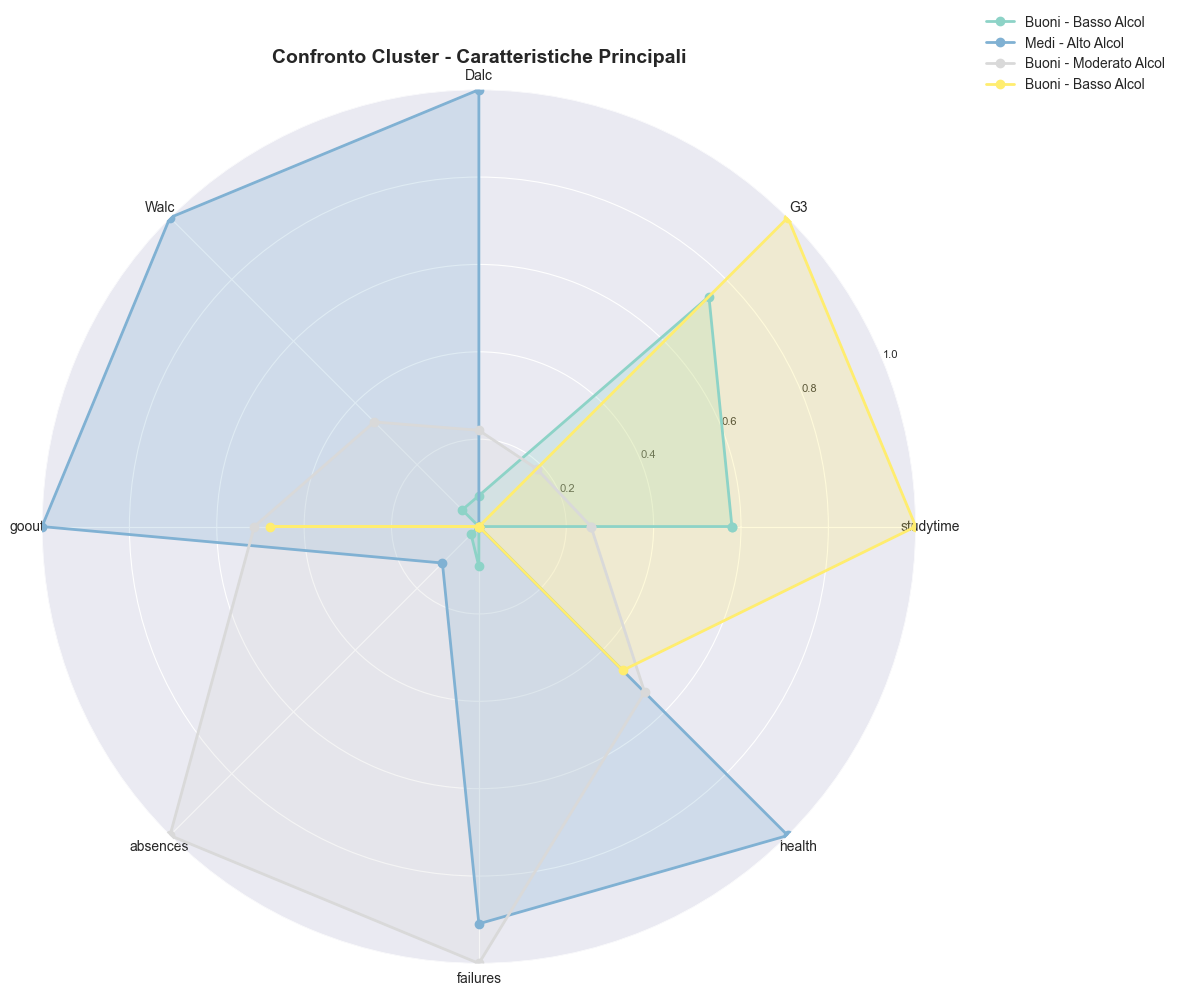

In [67]:
# Seleziona features chiave per il radar plot
key_features = [
    'studytime',  # Tempo di studio
    'G3',  # Voto finale
    'Dalc',  # Consumo alcol settimanale
    'Walc',  # Consumo alcol weekend
    'goout',  # Uscite sociali
    'absences',  # Assenze
    'failures',  # Insufficienze
    'health'  # Salute
]

# Filtra solo le features disponibili
key_features = [f for f in key_features if f in cluster_profiles.columns]

# Crea radar plot
create_radar_plot(cluster_profiles, key_features, cluster_names_dict, 
                 title="Confronto Cluster - Caratteristiche Principali")


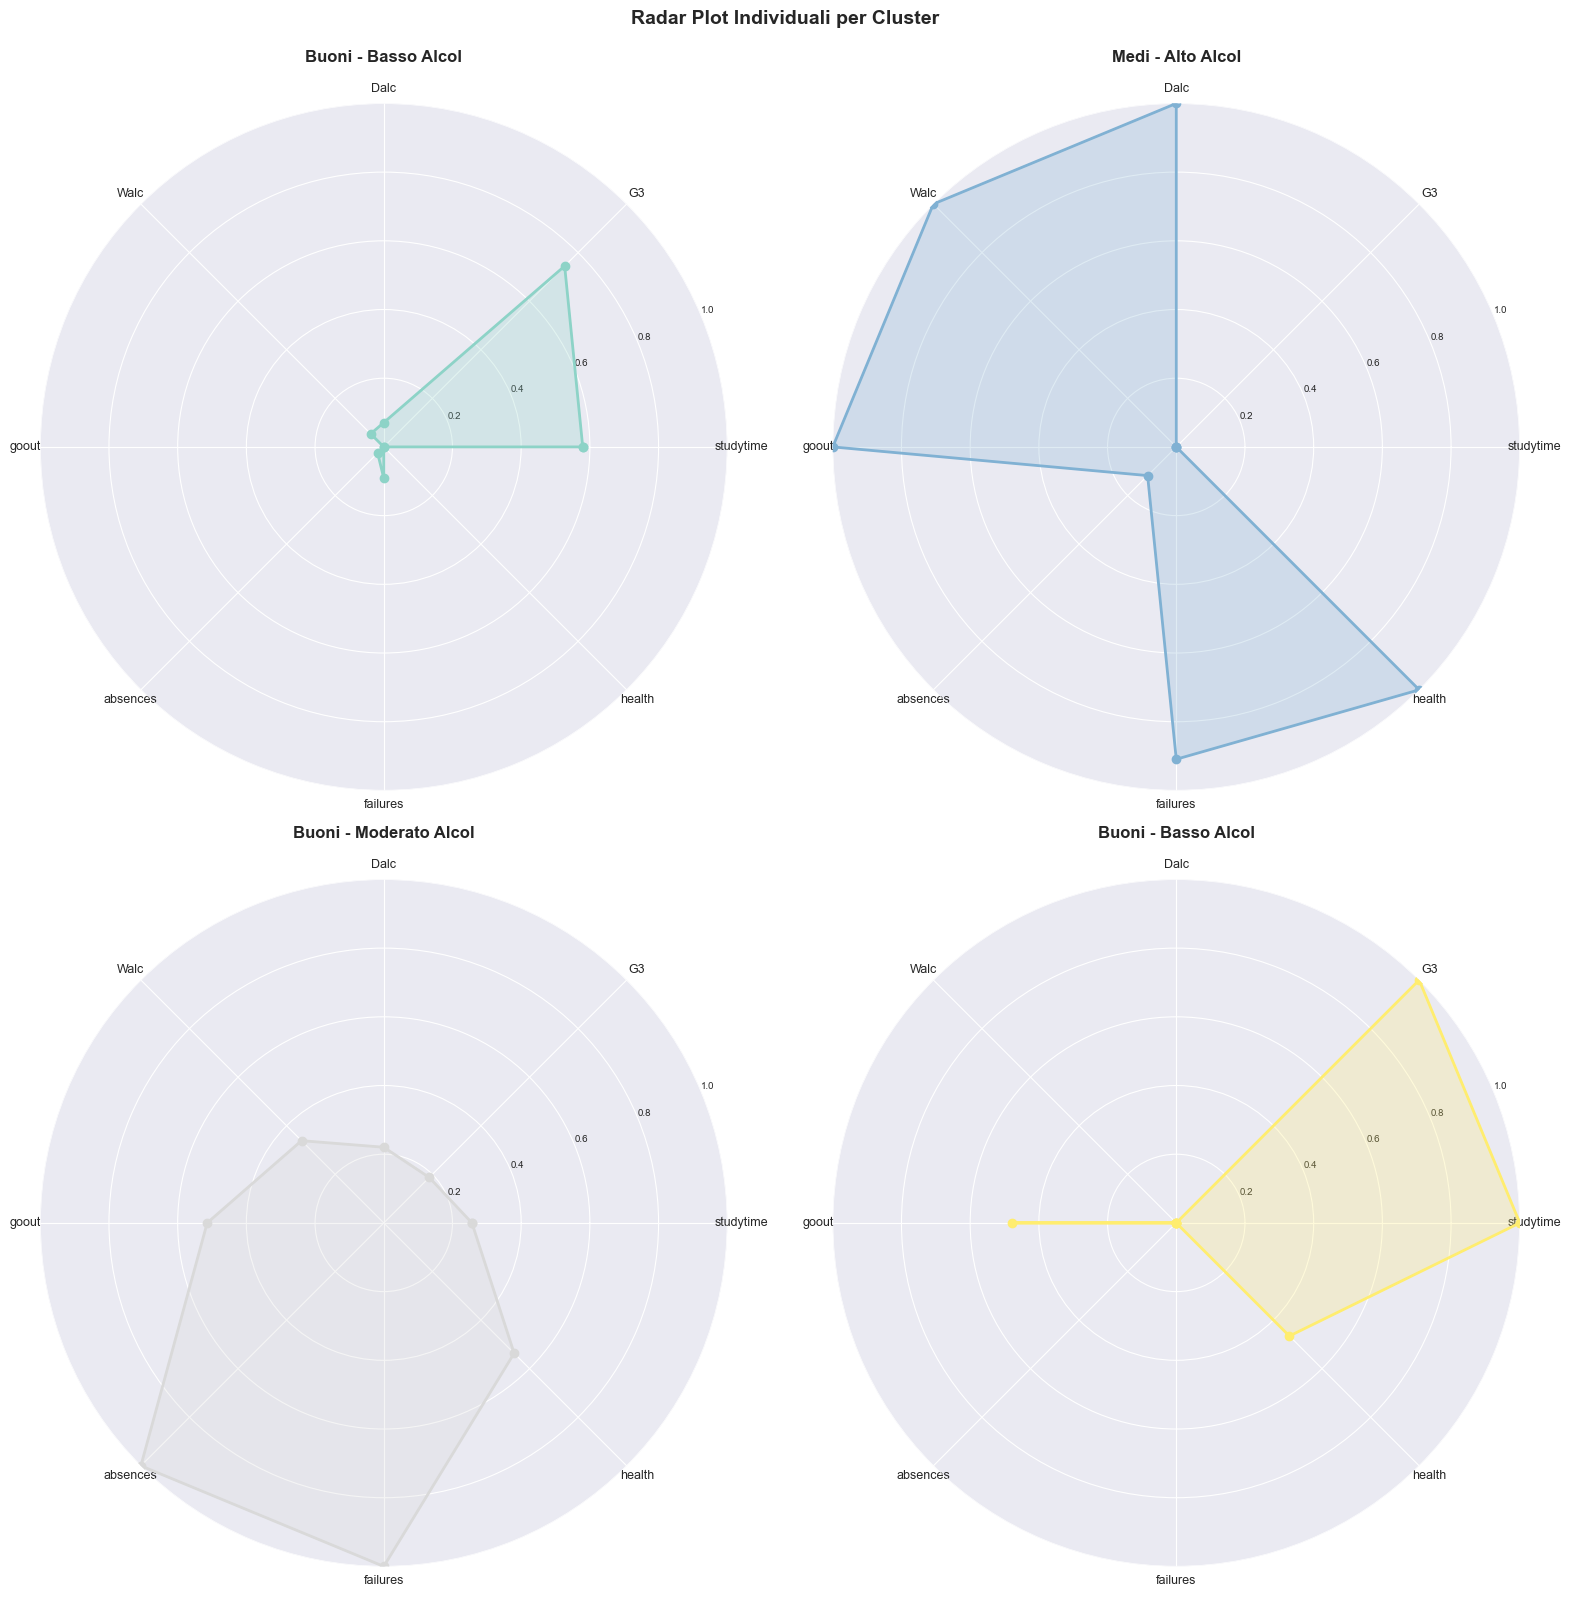

In [68]:
# Crea radar plot separati per ogni cluster (più dettagliati)
def create_individual_radar_plots(cluster_profiles, features_to_plot, cluster_names_dict):
    """
    Crea radar plot separati per ogni cluster
    """
    n_clusters = len(cluster_profiles)
    cols = 2
    rows = (n_clusters + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8*rows), subplot_kw=dict(projection='polar'))
    axes = axes.flatten() if n_clusters > 1 else [axes]
    
    # Normalizza le features
    normalized_profiles = cluster_profiles[features_to_plot].copy()
    for feature in features_to_plot:
        min_val = normalized_profiles[feature].min()
        max_val = normalized_profiles[feature].max()
        if max_val - min_val > 0:
            normalized_profiles[feature] = (normalized_profiles[feature] - min_val) / (max_val - min_val)
    
    N = len(features_to_plot)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    
    for idx, cluster_id in enumerate(cluster_profiles.index):
        ax = axes[idx]
        values = normalized_profiles.loc[cluster_id].values.tolist()
        values += values[:1]
        
        cluster_name = cluster_names_dict.get(cluster_id, f'Cluster {cluster_id}')
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features_to_plot, fontsize=9)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=7)
        ax.grid(True)
        ax.set_title(cluster_name, fontsize=12, fontweight='bold', pad=15)
    
    # Nascondi subplot non usati
    for idx in range(n_clusters, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Radar Plot Individuali per Cluster', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Crea radar plot individuali
create_individual_radar_plots(cluster_profiles, key_features, cluster_names_dict)


## 8. Riepilogo e Statistiche dei Cluster


In [69]:
# Crea profili anche per Hierarchical Clustering
cluster_profiles_hierarchical = df.groupby('cluster_hierarchical')[available_features + ['G1', 'G2', 'G3']].mean()
cluster_names_dict_hierarchical = assign_cluster_names(cluster_profiles_hierarchical)

print("Profilo medio dei cluster (Hierarchical Clustering):")
cluster_profiles_hierarchical


Profilo medio dei cluster (Hierarchical Clustering):


,age,Medu,Fedu,studytime,failures,absences,famrel,freetime,goout,Dalc,Walc,health,traveltime,G1,G2,G3
cluster_hierarchical,,,,,,,,,,,,,,,,
0,17.055249,2.243094,1.988950,1.563536,0.707182,9.767956,4.071823,3.900552,3.767956,1.408840,2.591160,3.823204,1.740331,10.033149,9.801105,9.812155
1,16.419802,2.895050,2.645545,2.253465,0.053465,2.516832,4.239604,3.348515,3.051485,1.247525,1.916832,3.667327,1.283168,11.881188,12.021782,12.196040
2,16.862454,2.353160,2.193309,1.810409,0.293680,3.743494,3.342007,2.327138,2.717472,1.249071,2.167286,3.115242,1.672862,11.130112,11.122677,11.171004
3,17.382022,2.438202,2.325843,1.674157,0.471910,6.561798,3.730337,3.584270,3.831461,3.808989,4.101124,3.561798,1.988764,10.078652,10.157303,10.123596


In [70]:
# Statistiche dettagliate per ogni cluster - K-MEANS
print("=" * 80)
print("RIEPILOGO CLUSTER - K-MEANS")
print("=" * 80)

for cluster_id in sorted(cluster_profiles.index):
    cluster_name = cluster_names_dict.get(cluster_id, f'Cluster {cluster_id}')
    profile = cluster_profiles.loc[cluster_id]
    n_students = len(df[df['cluster_kmeans'] == cluster_id])
    
    print(f"\n{cluster_name} (Cluster {cluster_id}) - {n_students} studenti")
    print("-" * 80)
    print(f"Voto medio (G3): {profile['G3']:.2f}")
    print(f"Tempo di studio: {profile['studytime']:.2f}")
    print(f"Assenze medie: {profile['absences']:.2f}")
    print(f"Insufficienze medie: {profile['failures']:.2f}")
    print(f"Consumo alcol settimanale (Dalc): {profile['Dalc']:.2f}")
    print(f"Consumo alcol weekend (Walc): {profile['Walc']:.2f}")
    print(f"Uscite sociali (goout): {profile['goout']:.2f}")
    print(f"Tempo libero (freetime): {profile['freetime']:.2f}")
    print(f"Salute: {profile['health']:.2f}")

print("\n" + "=" * 80)

# Statistiche dettagliate per ogni cluster - HIERARCHICAL CLUSTERING
print("\n" + "=" * 80)
print("RIEPILOGO CLUSTER - HIERARCHICAL CLUSTERING")
print("=" * 80)

for cluster_id in sorted(cluster_profiles_hierarchical.index):
    cluster_name = cluster_names_dict_hierarchical.get(cluster_id, f'Cluster {cluster_id}')
    profile = cluster_profiles_hierarchical.loc[cluster_id]
    n_students = len(df[df['cluster_hierarchical'] == cluster_id])
    
    print(f"\n{cluster_name} (Cluster {cluster_id}) - {n_students} studenti")
    print("-" * 80)
    print(f"Voto medio (G3): {profile['G3']:.2f}")
    print(f"Tempo di studio: {profile['studytime']:.2f}")
    print(f"Assenze medie: {profile['absences']:.2f}")
    print(f"Insufficienze medie: {profile['failures']:.2f}")
    print(f"Consumo alcol settimanale (Dalc): {profile['Dalc']:.2f}")
    print(f"Consumo alcol weekend (Walc): {profile['Walc']:.2f}")
    print(f"Uscite sociali (goout): {profile['goout']:.2f}")
    print(f"Tempo libero (freetime): {profile['freetime']:.2f}")
    print(f"Salute: {profile['health']:.2f}")

print("\n" + "=" * 80)


RIEPILOGO CLUSTER - K-MEANS

Buoni - Basso Alcol (Cluster 0) - 296 studenti
--------------------------------------------------------------------------------
Voto medio (G3): 11.44
Tempo di studio: 1.92
Assenze medie: 3.14
Insufficienze medie: 0.20
Consumo alcol settimanale (Dalc): 1.24
Consumo alcol weekend (Walc): 1.93
Uscite sociali (goout): 2.53
Tempo libero (freetime): 2.17
Salute: 3.22

Medi - Alto Alcol (Cluster 1) - 178 studenti
--------------------------------------------------------------------------------
Voto medio (G3): 9.92
Tempo di studio: 1.53
Assenze medie: 4.72
Insufficienze medie: 0.51
Consumo alcol settimanale (Dalc): 2.98
Consumo alcol weekend (Walc): 4.06
Uscite sociali (goout): 3.98
Tempo libero (freetime): 3.72
Salute: 3.97

Buoni - Moderato Alcol (Cluster 2) - 77 studenti
--------------------------------------------------------------------------------
Voto medio (G3): 10.30
Tempo di studio: 1.70
Assenze medie: 19.78
Insufficienze medie: 0.55
Consumo alcol settim

In [71]:
# Statistiche dettagliate per ogni cluster
print("=" * 80)
print("RIEPILOGO CLUSTER")
print("=" * 80)

for cluster_id in sorted(cluster_profiles.index):
    cluster_name = cluster_names_dict.get(cluster_id, f'Cluster {cluster_id}')
    profile = cluster_profiles.loc[cluster_id]
    n_students = len(df[df['cluster_kmeans'] == cluster_id])
    
    print(f"\n{cluster_name} (Cluster {cluster_id}) - {n_students} studenti")
    print("-" * 80)
    print(f"Voto medio (G3): {profile['G3']:.2f}")
    print(f"Tempo di studio: {profile['studytime']:.2f}")
    print(f"Assenze medie: {profile['absences']:.2f}")
    print(f"Insufficienze medie: {profile['failures']:.2f}")
    print(f"Consumo alcol settimanale (Dalc): {profile['Dalc']:.2f}")
    print(f"Consumo alcol weekend (Walc): {profile['Walc']:.2f}")
    print(f"Uscite sociali (goout): {profile['goout']:.2f}")
    print(f"Tempo libero (freetime): {profile['freetime']:.2f}")
    print(f"Salute: {profile['health']:.2f}")

print("\n" + "=" * 80)


RIEPILOGO CLUSTER

Buoni - Basso Alcol (Cluster 0) - 296 studenti
--------------------------------------------------------------------------------
Voto medio (G3): 11.44
Tempo di studio: 1.92
Assenze medie: 3.14
Insufficienze medie: 0.20
Consumo alcol settimanale (Dalc): 1.24
Consumo alcol weekend (Walc): 1.93
Uscite sociali (goout): 2.53
Tempo libero (freetime): 2.17
Salute: 3.22

Medi - Alto Alcol (Cluster 1) - 178 studenti
--------------------------------------------------------------------------------
Voto medio (G3): 9.92
Tempo di studio: 1.53
Assenze medie: 4.72
Insufficienze medie: 0.51
Consumo alcol settimanale (Dalc): 2.98
Consumo alcol weekend (Walc): 4.06
Uscite sociali (goout): 3.98
Tempo libero (freetime): 3.72
Salute: 3.97

Buoni - Moderato Alcol (Cluster 2) - 77 studenti
--------------------------------------------------------------------------------
Voto medio (G3): 10.30
Tempo di studio: 1.70
Assenze medie: 19.78
Insufficienze medie: 0.55
Consumo alcol settimanale (Dal

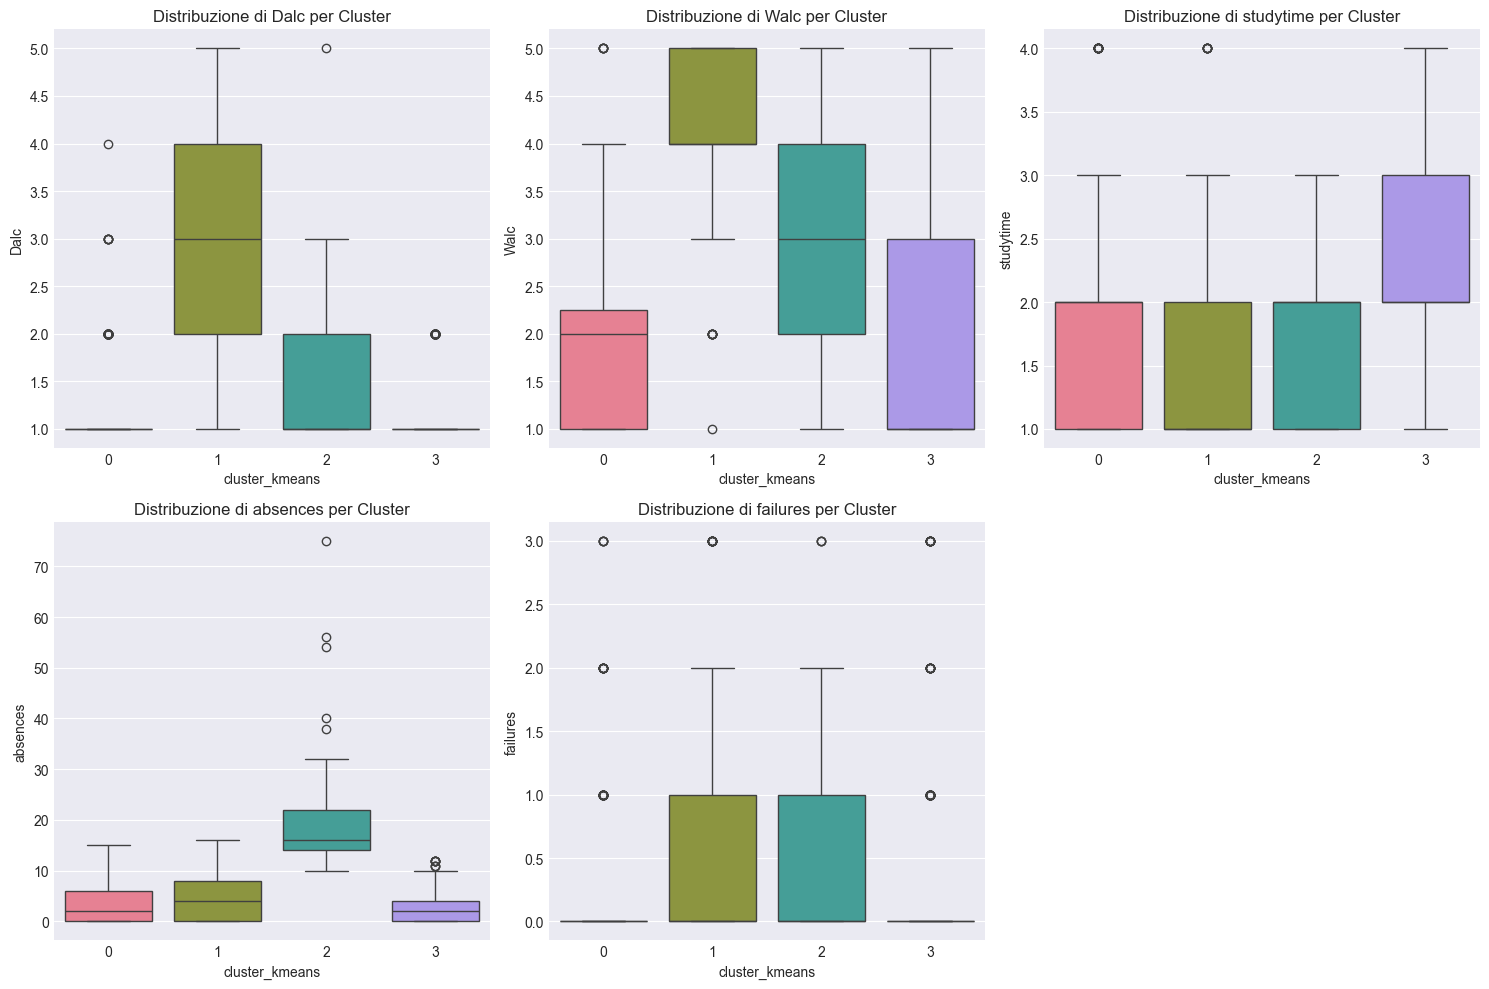

In [ ]:
# Per le variabili più importanti
cols_to_plot = ['Dalc', 'Walc', 'studytime', 'absences', 'failures']
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='cluster_kmeans', y=col, data=df, palette="husl")
    plt.title(f'Distribuzione di {col} per Cluster')
plt.tight_layout()
plt.show()

In [73]:
# Salva i risultati
df_with_clusters = df.copy()
df_with_clusters.to_excel("df_merge_with_clusters.xlsx", index=False)
print("Dataset con cluster salvato in 'df_merge_with_clusters.xlsx'")


Dataset con cluster salvato in 'df_merge_with_clusters.xlsx'
